# Titanic Survival Prediction
This analysis aims to build a machine learning model to predict the survival of passengers aboar the Titanic using various attributes such as class, age, and sex. The dataset is available through Kaggle and contains information on 891 passengers. This notebook includes preprocessing data, handling missing values, and relevant feature engineering. A Random Forest Classifier will be used as a baseline model to predict survival.

## 1. Dependencies & Data Loading
The dataset for this analysis was obtained from Kaggle. Link: https://www.kaggle.com/datasets/yasserh/titanic-dataset?resource=download

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,  classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

sns.set_style('darkgrid')

In [107]:
# load data into pandas
df = pd.read_csv("Titanic-Dataset.csv")

## 2. Initial Data Exploration

In [108]:
# Renaming Parent/Child column 'ParCh' for consistency with Sibling/Spouse column 'SibSp'
df.rename(columns={'Parch': 'ParCh'}, inplace=True)

# Inspecting the data
print(df.head(),"\n")
print("Shape: ", df.shape)
print("Columns: ", df.columns)
print("Info: ", df.info())
print("Describe: ", df.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   ParCh            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S   



From the description of the dataset above, we can see that it has the following 12 columns:
- PassengerId: integer index, a unique key for each passenger
- Survived: binary feature marking survival
- Pclass: numerical marking class 
- Name: Last, first. First name includes title, can include alternative name in quotes or parentheses
- Sex: male or female
- Age: int
- SibSp: counts siblings or spouse aboard
- Parch: counts parents or children aboard
- Ticket: ticket number
- Fare: numerical passenger fare
- Cabin: cabin number
- Embarked: embark port (C = Cherbourg, Q = Queenstown, S = Southampton)

## 3. Handling Missing Values & Preprocessing

In [109]:
# Checking for missing values
print("Missing value counts, from 891 rows:\n", df.isnull().sum())

Missing value counts, from 891 rows:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
ParCh            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Missing values need to be handled in the columns Age (177/891 missing), Cabin (687/891 missing), and Embarked (2/891 missing).
- Embarked has only 2 values missing.
- Cabin is missing for the majority of records.
- Age is missing for about 1/5 records.

### 3.1 Handling 'Embarked'
Because there are not many records, missing values can be resolved by dropping rows.

In [110]:
df = df.dropna(subset=['Embarked'])

### 3.2 Handling 'Cabin' and Creating 'Deck' and 'HasCabin'

Handling missing cabin values is more complex, as the majority are missing. Inspecting ticket groups tells us that many tickets come with mulitple passengers in the same cabin or close cabins. We can use this to impute a small number of missing values. However, the majority of cabin values will still be missing, so a new binary feature, HasCabin, is created. For the values we do know, we can focus on extracting the deck level, as this is likely to have an impact on survival.

In [111]:
# print information about passengers on the same ticket
ticket_counts = df['Ticket'].value_counts()
for ticket, count in ticket_counts[ticket_counts > 1].items():
    print(f"\nTicket: {ticket}, Count: {count}")
    print(df[df['Ticket'] == ticket][['Name', 'Cabin', 'Pclass', 'SibSp', 'ParCh']])


Ticket: 347082, Count: 7
                                                  Name Cabin  Pclass  SibSp  \
13                         Andersson, Mr. Anders Johan   NaN       3      1   
119                  Andersson, Miss. Ellis Anna Maria   NaN       3      4   
541               Andersson, Miss. Ingeborg Constanzia   NaN       3      4   
542                  Andersson, Miss. Sigrid Elisabeth   NaN       3      4   
610  Andersson, Mrs. Anders Johan (Alfrida Konstant...   NaN       3      1   
813                 Andersson, Miss. Ebba Iris Alfrida   NaN       3      4   
850            Andersson, Master. Sigvard Harald Elias   NaN       3      4   

     ParCh  
13       5  
119      2  
541      2  
542      2  
610      5  
813      2  
850      2  

Ticket: 1601, Count: 7
                Name Cabin  Pclass  SibSp  ParCh
74     Bing, Mr. Lee   NaN       3      0      0
169    Ling, Mr. Lee   NaN       3      0      0
509   Lang, Mr. Fang   NaN       3      0      0
643  Foo, Mr. Cho

In [112]:
# Create a new feature, deck, based on cabin
df['Deck'] = df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else np.nan)

# finds the most common deck for each ticket group, if data exists
deck_mode = df.groupby('Ticket')['Deck'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)


def infer_deck(row):
    # If deck exists, keep it
    if pd.notnull(row['Deck']):
        return row['Deck']
    # Else, if data is available, fill with mode deck of the ticket group
    return deck_mode.get(row['Ticket'], np.nan)

# Run deck imputation, create binary cabin feature, drop original cabin data
df['Deck'] = df.apply(infer_deck, axis=1)
df['HasCabin'] = df['Deck'].notnull().astype(int)
df['Deck'] = df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'U')
df.drop('Cabin', axis=1)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Embarked,Deck,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,U,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,U,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,U,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,U,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,B,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S,U,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,1


### 3.3 Extracting 'Title' for Imputation & Modeling

We extract the passenger's title (e.g., Mr, Miss, Dr) from the name field using regular expression. 
This feature is useful both as a predictor for age (younger titles like "Master" or "Miss" imply lower age) and later as a feature for survival prediction.
Less common titles are grouped as "Other" to reduce noise.

In [113]:
# Creates title feature
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

# Labels rare titles as "Other" to simplify noise
title_counts = df['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Other')


### 3.4 Imputing Age with Random Forest

Roughly 20% of the age values are missing, and there is correlation between age and other features in the dataset. To address this, imputation is used to fill in the missing age values.

A Random Forest model was selected to impute age. Random Forest works for this task because it can capture complex relationships between features, which a simple imputation method cannot do. It is flexible, can handle both numeric and categorical variables, and can consider multiple features simultaneously to generate more reliable age predictions. Additionally, it remains fairly resistant to overfitting. Although Random Forest models can be computationally expensive, the small size of this dataset means efficiency is not significantly impacted. Alternatively, median-based imputation through groups could provide reasonably accurate imputation.


Correlation Matrix:              Age      Fare     SibSp     ParCh
Age    1.000000  0.093143 -0.307351 -0.187896
Fare   0.093143  1.000000  0.160887  0.217532
SibSp -0.307351  0.160887  1.000000  0.414542
ParCh -0.187896  0.217532  0.414542  1.000000


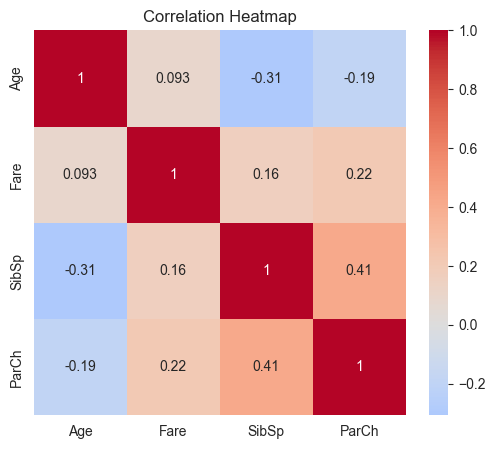

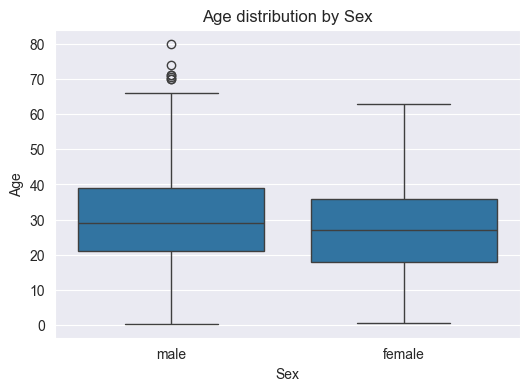

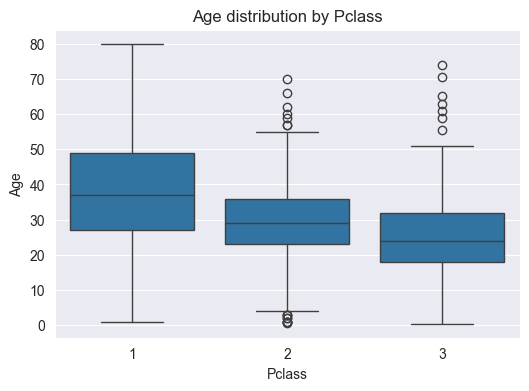

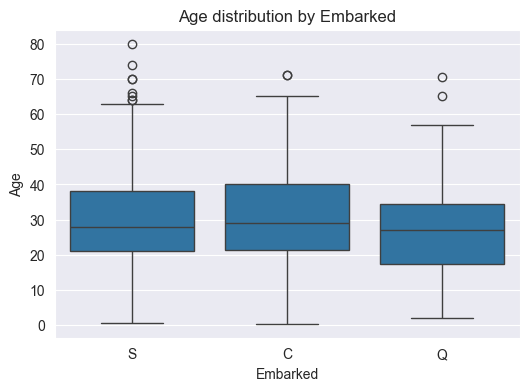

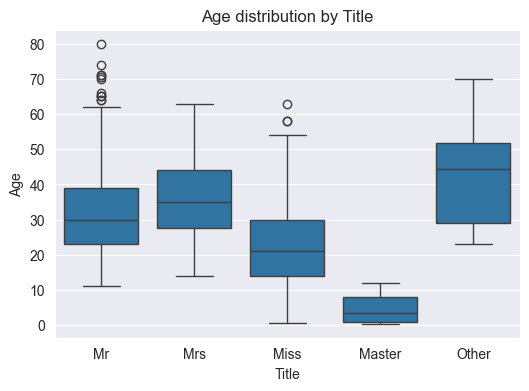

In [114]:

# Exploring correlations between age & numeric features
numeric_vars = ['Age', 'Fare', 'SibSp', 'ParCh']
corr_matrix = df[numeric_vars].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
print("Correlation Matrix: ", corr_matrix)
plt.show()

# Exploring correlations between age & categorical features
categorical_vars = ['Sex', 'Pclass', 'Embarked', 'Title']
for category in categorical_vars:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=category, y='Age', data=df)
    plt.title(f'Age distribution by {category}')
    plt.show()


R^2:  0.46474348456396763
MSE:  130.57630987292535


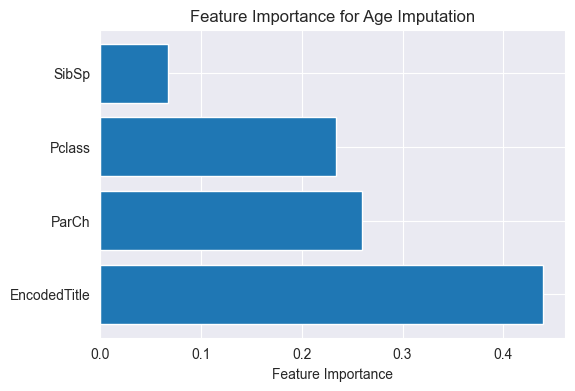

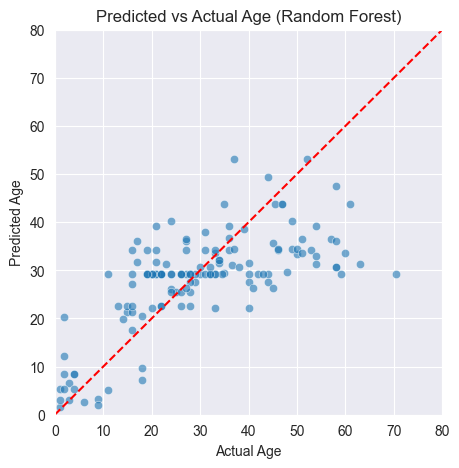

In [115]:
# Random Forest Model for Age Imputation

# Uses label encoding on title so it can be included
le_title = LabelEncoder()
df['EncodedTitle'] = le_title.fit_transform(df['Title'])

# features we will be using in the model
age_features = ['SibSp', 'ParCh', 'Pclass', 'EncodedTitle']

# filter where data for age is missing
age_known = df[df['Age'].notnull()]
age_unknown = df[df['Age'].isnull()]

X = age_known[age_features]
y = age_known['Age']


# first training the model on 80% of the known data to evaluate effectiveness
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(X, y, test_size=0.2, random_state=42)

rf_eval = RandomForestRegressor(n_estimators=100, random_state=42)
rf_eval.fit(X_train_eval, y_train_eval)
y_pred_eval = rf_eval.predict(X_test_eval)

print("R^2: ", r2_score(y_test_eval, y_pred_eval))
print("MSE: ", mean_squared_error(y_test_eval, y_pred_eval))



# making the final imputation model on all known data
rf_final = RandomForestRegressor(n_estimators=100, random_state=42)
rf_final.fit(X, y)


# assign features to model
df.loc[df['Age'].isnull(), 'Age'] = rf_final.predict(age_unknown[age_features])


# graphing importance of features in model
feature_importance = rf_final.feature_importances_

sorted_idx = np.argsort(feature_importance)[::-1]
sorted_importances = feature_importance[sorted_idx]
sorted_features = [age_features[i] for i in sorted_idx]

plt.figure(figsize=(6,4))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Age Imputation')
plt.show()


# Plotting predicted values against perfect performance
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_test_eval, y=y_pred_eval, alpha=0.6)
plt.plot([0, 80], [0, 80], color='red', linestyle='--') 
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs Actual Age (Random Forest)')
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.show()


The Random Forest regressor model was trained on relevant features and has an R-squared score of approximately .46 & a mean squred error of 130.6. This indicates that the model accounts for almost half of the variance in passenger ages, which is acceptable due to the noise and missing data. While other imputation methods like median group-based imputation can provide baseline estimates, the Random Forest model can capture interactions among multiple features and can provide a more robust approach towards missing data.

## 4. Feature Engineering

### 4.1 Label Encoding for Categorical Features
Categorical features that could affect our model must be encoded. Because the model will be tree-based, label encoding is used.

In [116]:
le_deck = LabelEncoder()
df['EncodedDeck'] = le_deck.fit_transform(df['Deck'])

le_sex = LabelEncoder()
df['EncodedSex'] = le_sex.fit_transform(df['Sex'])

le_embarked = LabelEncoder()
df['EncodedEmbarked'] = le_embarked.fit_transform(df['Embarked'])

### 4.2 Interaction Features
Features capturing interactions between variables like age, sex, and title can provide nuance and insight into underlying relations in the data. For example, SexByAge could capture different survival rates among age groups for each sex.

In [117]:
# Age and title interaction
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 13, 18, 36, 60, 100], labels=False)
df['TitleByAgeGroup'] = df['EncodedTitle'] * df['AgeGroup']

# Sex and age interaction
df['SexByAge'] = df['EncodedSex'] * df['Age']

### 4.3 Family-Based Features
Creating features from Age, SibSp, and ParCh provides insight into whether someone is traveling in a group. The feature FamilySize is created based on SibSp and ParCh (along with the individual), which is then used to create a more simple binary feature IsAlone.

In [118]:
df['Child'] = df['Age'].apply(lambda x: 1 if x < 13 else 0)
df['FamilySize'] = df['SibSp'] + df['ParCh'] + 1
df['IsAlone'] = df['FamilySize'].apply(lambda x:1 if x == 1 else 0)

## 5. Data Exploration on Survival

This section explores correlations between different features and overall survival.

Sex, age, and deck will likely have significant impacts as they determine lifeboat prioritization & accessiblity. A new feature 'child' is created to capture distinction in age. 
Having family on board also affects survival chances. The feature FamilySize is created based on SibSp and ParCh (along with the individual), along with a more simple binary feature IsAlone.

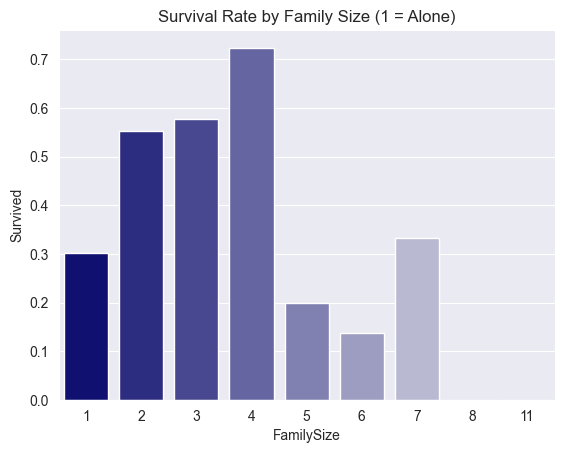

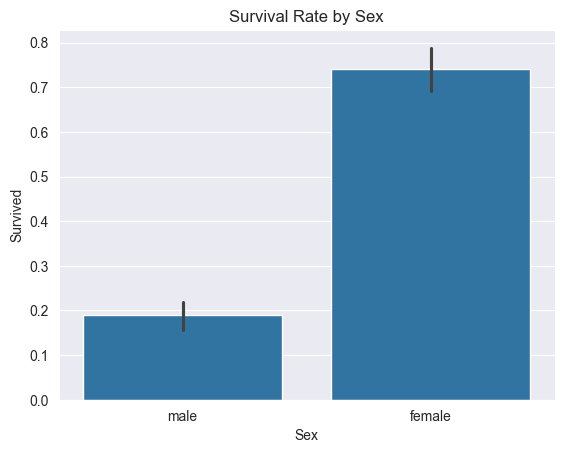

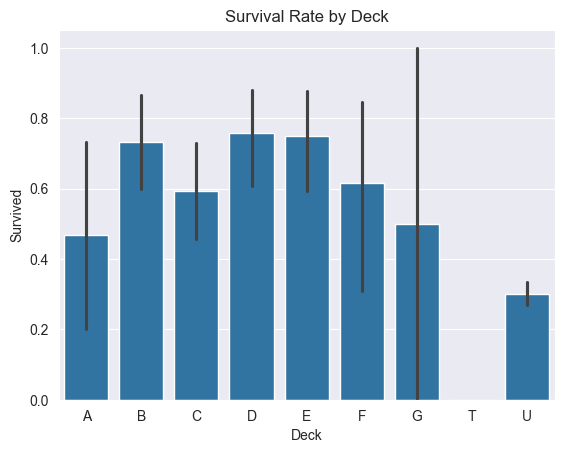

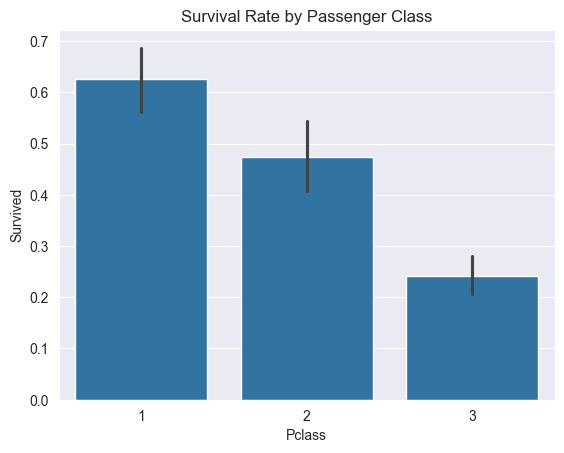

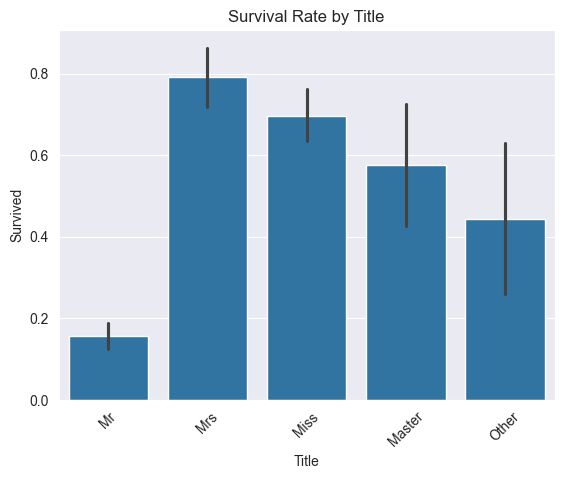

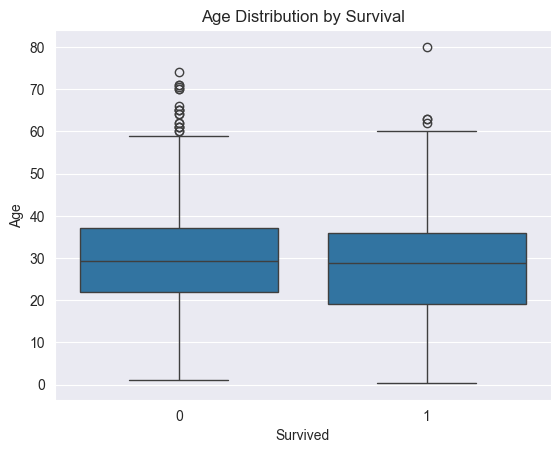

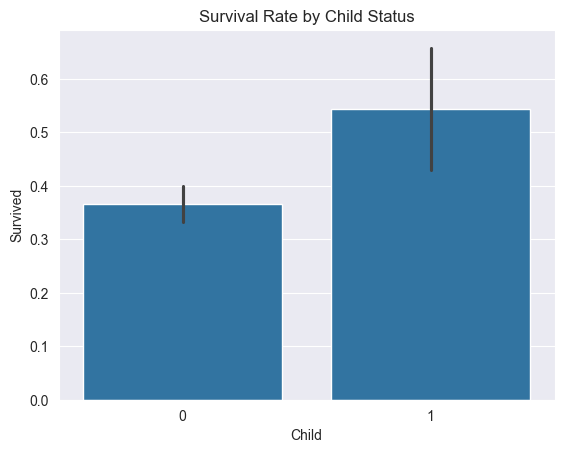

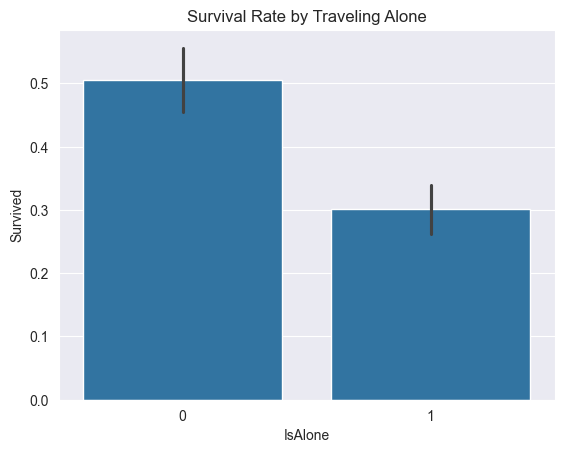

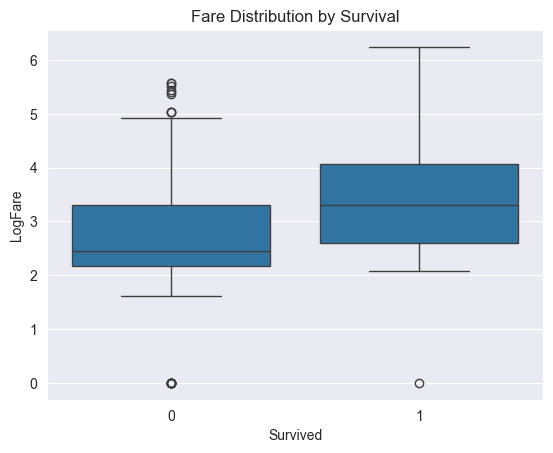

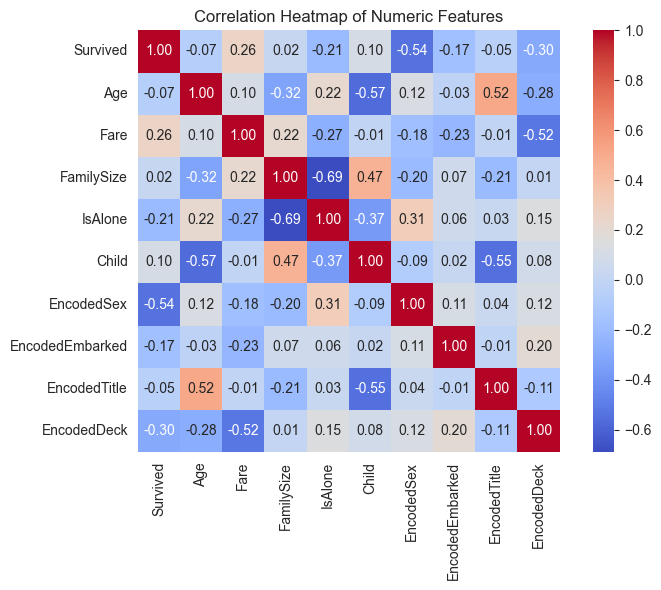

In [119]:


# Plotting effect of family size on survival, visual weight representing frequency
counts = df['FamilySize'].value_counts().sort_index()
normalized_counts = (counts - counts.min()) / (counts.max() - counts.min())
palette = sns.light_palette("navy", reverse=True, n_colors=len(normalized_counts))
color_map = {size: palette[i] for i, size in enumerate(normalized_counts.index)}
sns.barplot(x='FamilySize', y='Survived', data=df, errorbar=None, hue='FamilySize', palette=color_map, dodge=False)
plt.legend([],[],frameon=False) # remove legend
plt.title('Survival Rate by Family Size (1 = Alone)')
plt.show()

# Plotting survival by sex
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival Rate by Sex')
plt.show()

# Survival by Deck
sns.barplot(x='Deck', y='Survived', data=df, order=sorted(df['Deck'].unique()))
plt.title('Survival Rate by Deck')
plt.show()

# Survival by Class
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival Rate by Passenger Class')
plt.show()

# Survival by Title
sns.barplot(x='Title', y='Survived', data=df)
plt.title('Survival Rate by Title')
plt.xticks(rotation=45)
plt.show()

# Survival by Age
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Age Distribution by Survival')
plt.show()

# Survival by Child 
sns.barplot(x='Child', y='Survived', data=df)
plt.title('Survival Rate by Child Status')
plt.show()

# Survival of Alone
sns.barplot(x='IsAlone', y='Survived', data=df)
plt.title('Survival Rate by Traveling Alone')
plt.show()

df['LogFare'] = np.log1p(df['Fare'])
# Survival by Fare
sns.boxplot(x='Survived', y='LogFare', data=df)
plt.title('Fare Distribution by Survival')
plt.show()

# Correlation Heatmap for numeric features
numeric_features = ['Survived', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Child', 'EncodedSex', 'EncodedEmbarked', 'EncodedTitle', 'EncodedDeck']
corr_matrix = df[numeric_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


The plots show that sex and age are strong predictors of survival. Whether or not an individual is alone also has a moderate effect. 

A random forest classifier model will be used to predict survival.
Additional combination features (ie, SexByAge) can be used to boost model accuracy by finding nuanced interactions between variables. Less relevant features that add noise can be removed.

## 6. Survival Prediction Model with Random Forest

### 6.1 Fitting Model
Given the Titanic dataset’s mix of categorical and continuous variables, relatively small size, and complex underlying relationships, Random Forest provides a strong baseline model for survival prediction with good balance between accuracy and interpretability. It works by building several decision treees and combining their results to get more accurate and stable predictions, while being less likely to overfit.

In [120]:
# Random Forest Classifier

# feature selection
features = ['Pclass', 'EncodedSex', 'Age', 'Fare', 'IsAlone', 'Child', 'EncodedEmbarked', 'EncodedTitle', 'EncodedDeck', 'HasCabin', 'SexByAge', 'TitleByAgeGroup']
target = 'Survived'

X = df[features]
y = df[target]


# 20% of the data is saved for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create model
clf = RandomForestClassifier(n_estimators=75, random_state=42)

# cross validation on the training set
cv_scores = cross_val_score(clf, X, y, cv=10)
print(f"Mean CV Accuracy: {cv_scores.mean()}")

# fit model to training set
clf.fit(X_train, y_train)

# evaluate model on test set
y_pred = clf.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

Mean CV Accuracy: 0.8166879468845762
Test Set Accuracy: 0.8146067415730337


### 6.2 Model Evaluation


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84       109
           1       0.74      0.81      0.77        69

    accuracy                           0.81       178
   macro avg       0.80      0.81      0.81       178
weighted avg       0.82      0.81      0.82       178


Confusion Matrix: [[89 20]
 [13 56]]


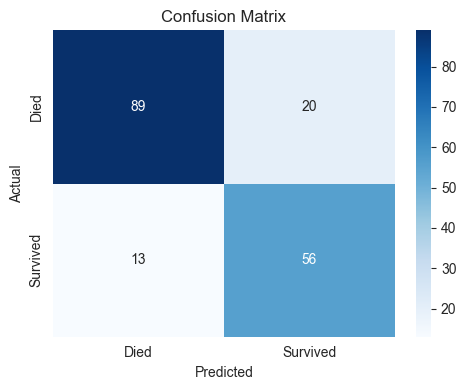

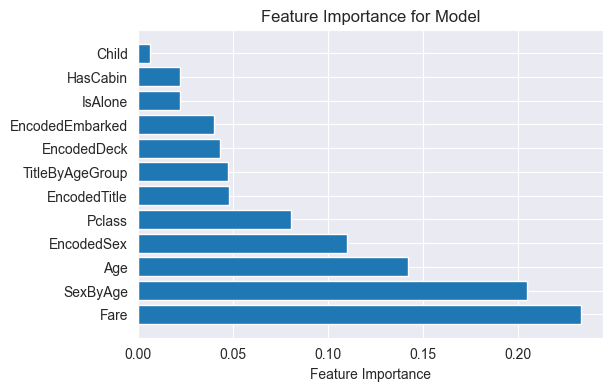

In [121]:

# evaluation metrics on test set
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:", confusion_matrix(y_test, y_pred))

# plots confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# plots feature importance
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_importances = feature_importance[sorted_idx]
sorted_features = [features[i] for i in sorted_idx]

plt.figure(figsize=(6,4))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Model')
plt.show()


## 7. Conclusion & Potential Improvement
The Random Forest Classifier created above provides a baseline for predicting Titanic survival, but there is room for improvement. Cross validation with 10 folds was used to achieve an accuracy of approximately 81.7%, with the hold-out test achieving 81.4% accuracy.  The classification report tells us that this model is slightly weaker at predicting survivors, and sometimes incorrectly predicts survivors where there are none. The precision score for Survived tells us that only 74% of the passengers predicted to survive were in fact survivors, implying room for finer tuning. The recall for survivors tells us that 81% of the predicted survivors did survive, but there are some false negatives. The F1 scores, which balances precision and recall, are 84% for non-survivors and 77% for survivors More precise feature engineering to consider nuanced interactions between variables could boost accuracy. Fine-tuning the hyperparameters of the model could also improve it. Further, using a gradient boosting method such as an XGBoost model would likely provide an increase in accuracy in exchange for more precise tuning. 